## 資料匯入&資料預處理

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
plt.rcParams['axes.unicode_minus']=False #正常顯示負號
plt.rcParams['font.family']='SimHei'   # 顯示中文 且為黑體
%matplotlib inline
plt.style.use('seaborn')
data = pd.read_csv('movie_metadata.csv')

#此為 未清理資料之資料集
raw_data = pd.read_csv('movie_metadata.csv')
data_color = pd.get_dummies(raw_data.color)    #將color內的值拆開
raw_color = raw_data.join(data_color)    #再將拆開的欄 加回到資料集中
raw_color.loc[:,'count'] = 1     #新增一欄 值皆為1

#刪除一些沒有要分析的欄
data = pd.read_csv('movie_metadata.csv')
data = data.drop(['movie_imdb_link', 'actor_1_name','actor_2_name','actor_3_name','director_name',\
             'aspect_ratio','plot_keywords','movie_facebook_likes'], axis=1)     
data = data.dropna().reset_index(drop=True)   # 清除資料中所有 有遺失值 的列 

data_color = pd.get_dummies(data.color)    #將color內的值拆開
df = data.join(data_color)    
data_rating = pd.get_dummies(data.content_rating)    #將content_rating(電影分級)內的值拆開  
df = df.join(data_rating)
df.loc[:,'count'] = 1     #新增一欄 值皆為1
df['title_year'] = df.title_year.astype('int')    #將 年 轉換成整數
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3824 entries, 0 to 3823
Data columns (total 35 columns):
color                        3824 non-null object
num_critic_for_reviews       3824 non-null float64
duration                     3824 non-null float64
director_facebook_likes      3824 non-null float64
actor_3_facebook_likes       3824 non-null float64
actor_1_facebook_likes       3824 non-null float64
gross                        3824 non-null float64
genres                       3824 non-null object
movie_title                  3824 non-null object
num_voted_users              3824 non-null int64
cast_total_facebook_likes    3824 non-null int64
facenumber_in_poster         3824 non-null float64
num_user_for_reviews         3824 non-null float64
language                     3824 non-null object
country                      3824 non-null object
content_rating               3824 non-null object
budget                       3824 non-null float64
title_year                   3824 no

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,movie_title,num_voted_users,...,M,NC-17,Not Rated,PG,PG-13,Passed,R,Unrated,X,count
0,Color,723.0,178.0,0.0,855.0,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,Avatar?,886204,...,0,0,0,0,1,0,0,0,0,1
1,Color,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End?,471220,...,0,0,0,0,1,0,0,0,0,1
2,Color,602.0,148.0,0.0,161.0,11000.0,200074175.0,Action|Adventure|Thriller,Spectre?,275868,...,0,0,0,0,1,0,0,0,0,1
3,Color,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,Action|Thriller,The Dark Knight Rises?,1144337,...,0,0,0,0,1,0,0,0,0,1
4,Color,462.0,132.0,475.0,530.0,640.0,73058679.0,Action|Adventure|Sci-Fi,John Carter?,212204,...,0,0,0,0,1,0,0,0,0,1


In [2]:
#時間序列轉換
year_timeseries = df[['title_year', 'gross', 'budget']]
year_timeseries = year_timeseries.set_index(year_timeseries['title_year'], drop = True)
del year_timeseries['title_year']
year_timeseries.index = pd.to_datetime(year_timeseries.index, format = '%Y')
year_timeseries.head()

,gross,budget
title_year,,
2009-01-01,760505847.0,237000000.0
2007-01-01,309404152.0,300000000.0
2015-01-01,200074175.0,245000000.0
2012-01-01,448130642.0,250000000.0
2012-01-01,73058679.0,263700000.0


In [3]:
# IMDB分數、票房、預算、海報中臉出現的數量 - 描述性統計
df[['imdb_score','gross','budget','duration','facenumber_in_poster']].describe()

,imdb_score,gross,budget,duration,facenumber_in_poster
count,3824.000000,3.824000e+03,3.824000e+03,3824.000000,3824.000000
mean,6.459440,5.174780e+07,4.551915e+07,110.020659,1.379707
std,1.057863,6.999886e+07,2.240589e+08,22.571544,2.042234
min,1.600000,1.620000e+02,2.180000e+02,37.000000,0.000000
25%,5.900000,7.494118e+06,1.000000e+07,95.000000,0.000000
50%,6.600000,2.887515e+07,2.500000e+07,106.000000,1.000000
75%,7.200000,6.605946e+07,5.000000e+07,120.000000,2.000000
max,9.300000,7.605058e+08,1.221550e+10,330.000000,43.000000


### 歷年 彩色/黑白 電影產量

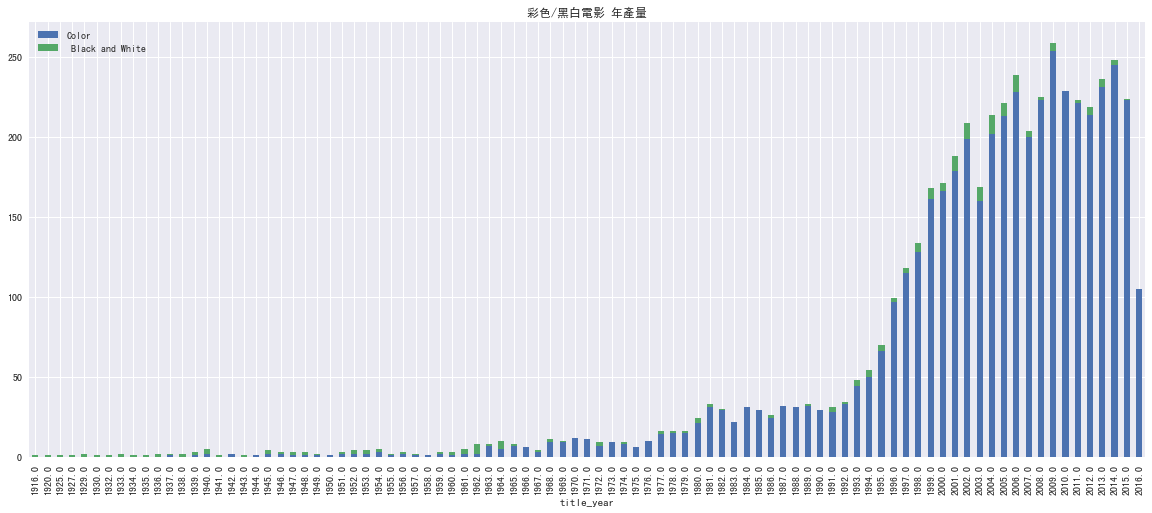

In [4]:
# 統計 每年產出的 彩色/黑白電影 產量 - 使用清理前之資料
df_color = raw_color.pivot_table(values='count', index='title_year',columns='color',aggfunc='sum')
df_color.head(3)

#未清理資料前的 彩色/黑白 電影數量
plt.rcParams['font.family']='SimHei' 
df_color = raw_color.groupby(['title_year'])[['Color',' Black and White']].sum()
df_color.plot(kind='bar',align='center',figsize=(20,8),stacked = True, grid = True, title = '彩色/黑白電影 年產量')


### 歷年 電影票房與預算

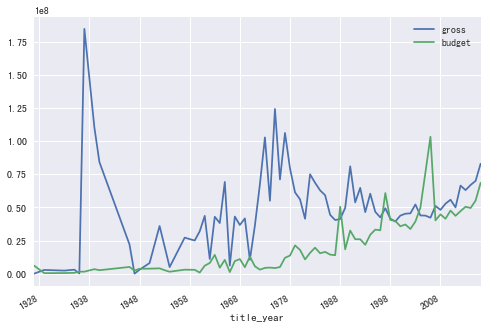

In [5]:
# 每年 電影票房與電影預算的平均 - 使用清理後之資料
df.groupby(['title_year'])[['gross','budget']].sum().head(3)

#電影預算與票房之趨勢
gross_budget = year_timeseries.groupby(year_timeseries.index).mean()
gross_budget.plot(kind = 'line')
# ps. 1937年美國出產的第一部彩色電影:白雪公主， 即是下圖中票房異常高的點

### 相關性分析

In [3]:
df_corr = data[['title_year','budget','gross','duration','actor_1_facebook_likes','actor_2_facebook_likes',\
                'actor_3_facebook_likes','director_facebook_likes','cast_total_facebook_likes','facenumber_in_poster',\
               'imdb_score','num_user_for_reviews','num_critic_for_reviews','num_voted_users']]
corr = df_corr.corr()
corr

,title_year,budget,gross,duration,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,imdb_score,num_user_for_reviews,num_critic_for_reviews,num_voted_users
title_year,1.000000,0.045306,0.048595,-0.130976,0.093216,0.118840,0.114556,-0.046379,0.123293,0.071783,-0.135675,0.012761,0.403909,0.017635
budget,0.045306,1.000000,0.101261,0.069537,0.017300,0.036639,0.040820,0.018943,0.029753,-0.021610,0.029843,0.072358,0.106975,0.067769
gross,0.048595,0.101261,1.000000,0.250621,0.146555,0.255090,0.301736,0.140721,0.238316,-0.030851,0.215467,0.548671,0.470389,0.627898
duration,-0.130976,0.069537,0.250621,1.000000,0.086179,0.131049,0.127920,0.182178,0.123075,0.026290,0.365819,0.355559,0.235976,0.343309
actor_1_facebook_likes,0.093216,0.017300,0.146555,0.086179,1.000000,0.390907,0.252568,0.090449,0.945025,0.061369,0.093854,0.124603,0.169435,0.181519
actor_2_facebook_likes,0.118840,0.036639,0.255090,0.131049,0.390907,1.000000,0.554029,0.117212,0.642393,0.072007,0.103094,0.189894,0.256579,0.247134
actor_3_facebook_likes,0.114556,0.040820,0.301736,0.127920,0.252568,0.554029,1.000000,0.118424,0.489492,0.105609,0.066116,0.207707,0.255082,0.269654
director_facebook_likes,-0.046379,0.018943,0.140721,0.182178,0.090449,0.117212,0.118424,1.000000,0.119609,-0.047901,0.191550,0.219199,0.177899,0.301234
cast_total_facebook_likes,0.123293,0.029753,0.238316,0.123075,0.945025,0.642393,0.489492,0.119609,1.000000,0.083728,0.107205,0.181834,0.240450,0.251428
facenumber_in_poster,0.071783,-0.021610,-0.030851,0.026290,0.061369,0.072007,0.105609,-0.047901,0.083728,1.000000,-0.066981,-0.080754,-0.034717,-0.032610


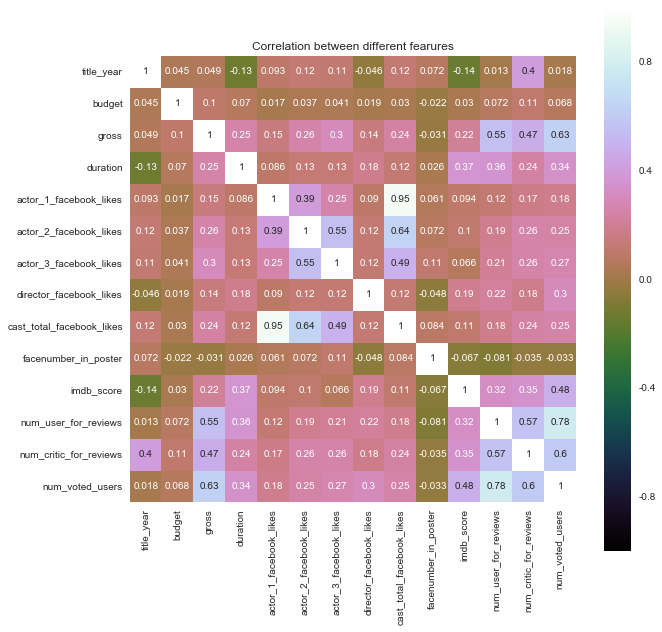

In [4]:
plt.figure(figsize=(10,10))
sns.heatmap(corr, vmax=1, square=True, annot=True, cmap='cubehelix')

plt.title('Correlation between different fearures')

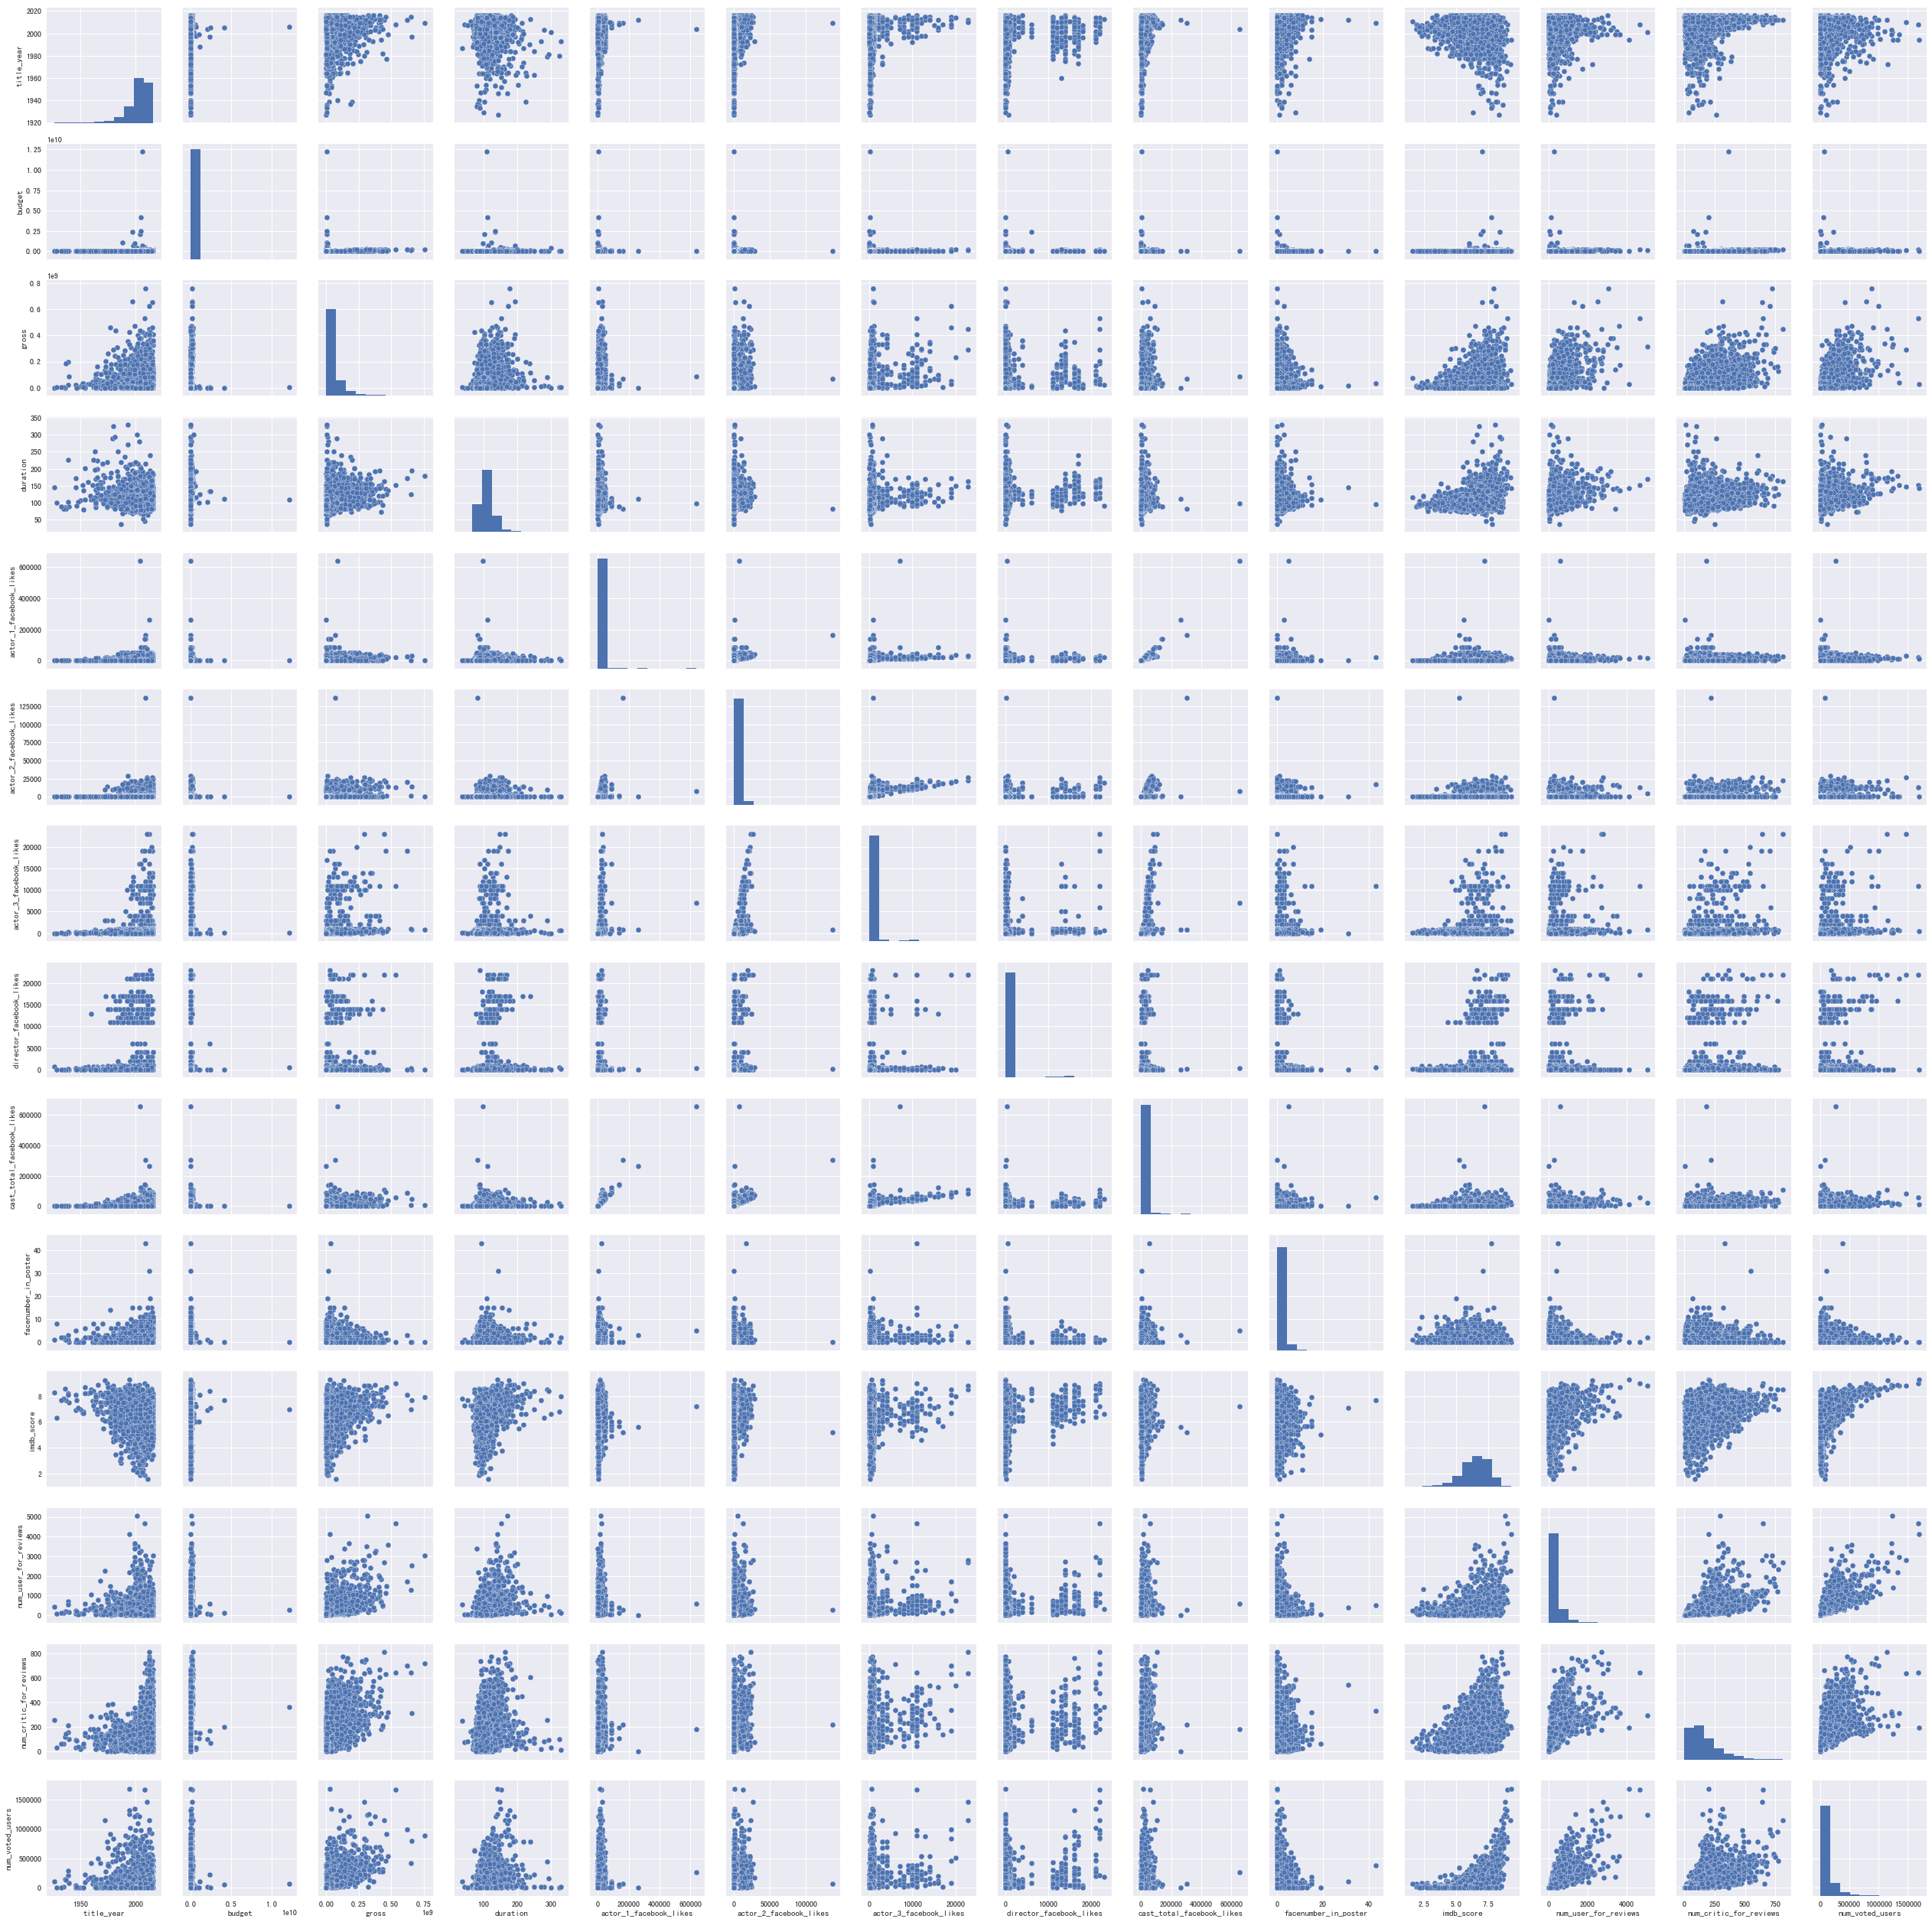

In [7]:
df_corr = data[['title_year','budget','gross','duration','actor_1_facebook_likes','actor_2_facebook_likes',\
                'actor_3_facebook_likes','director_facebook_likes','cast_total_facebook_likes','facenumber_in_poster',\
               'imdb_score','num_user_for_reviews','num_critic_for_reviews','num_voted_users']]
sns.pairplot(df_corr)

### IMDB 分數之分佈

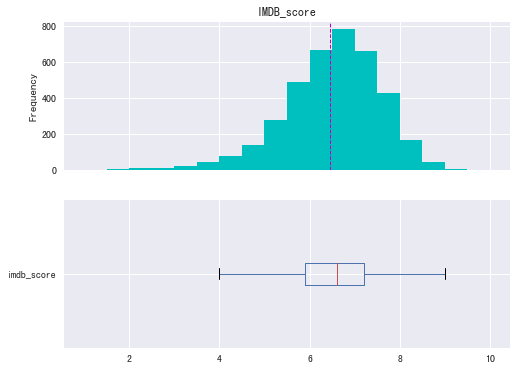

In [8]:
#所有電影 IMDB_score之分佈
plt.figure( figsize = (8,6) )

ax1 = plt.subplot(211)
imdb_score = df['imdb_score']
imdb_score.plot(kind = 'hist', bins=[1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10], color = 'c')
plt.title('IMDB_score')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.axvline(imdb_score.mean(), color='m', linestyle='dashed', linewidth=1)

plt.subplot(212, sharex = ax1)
imdb_score.plot(kind = 'box', vert=False, grid = True,  showfliers=True)

### 歷年IMDB_score分佈

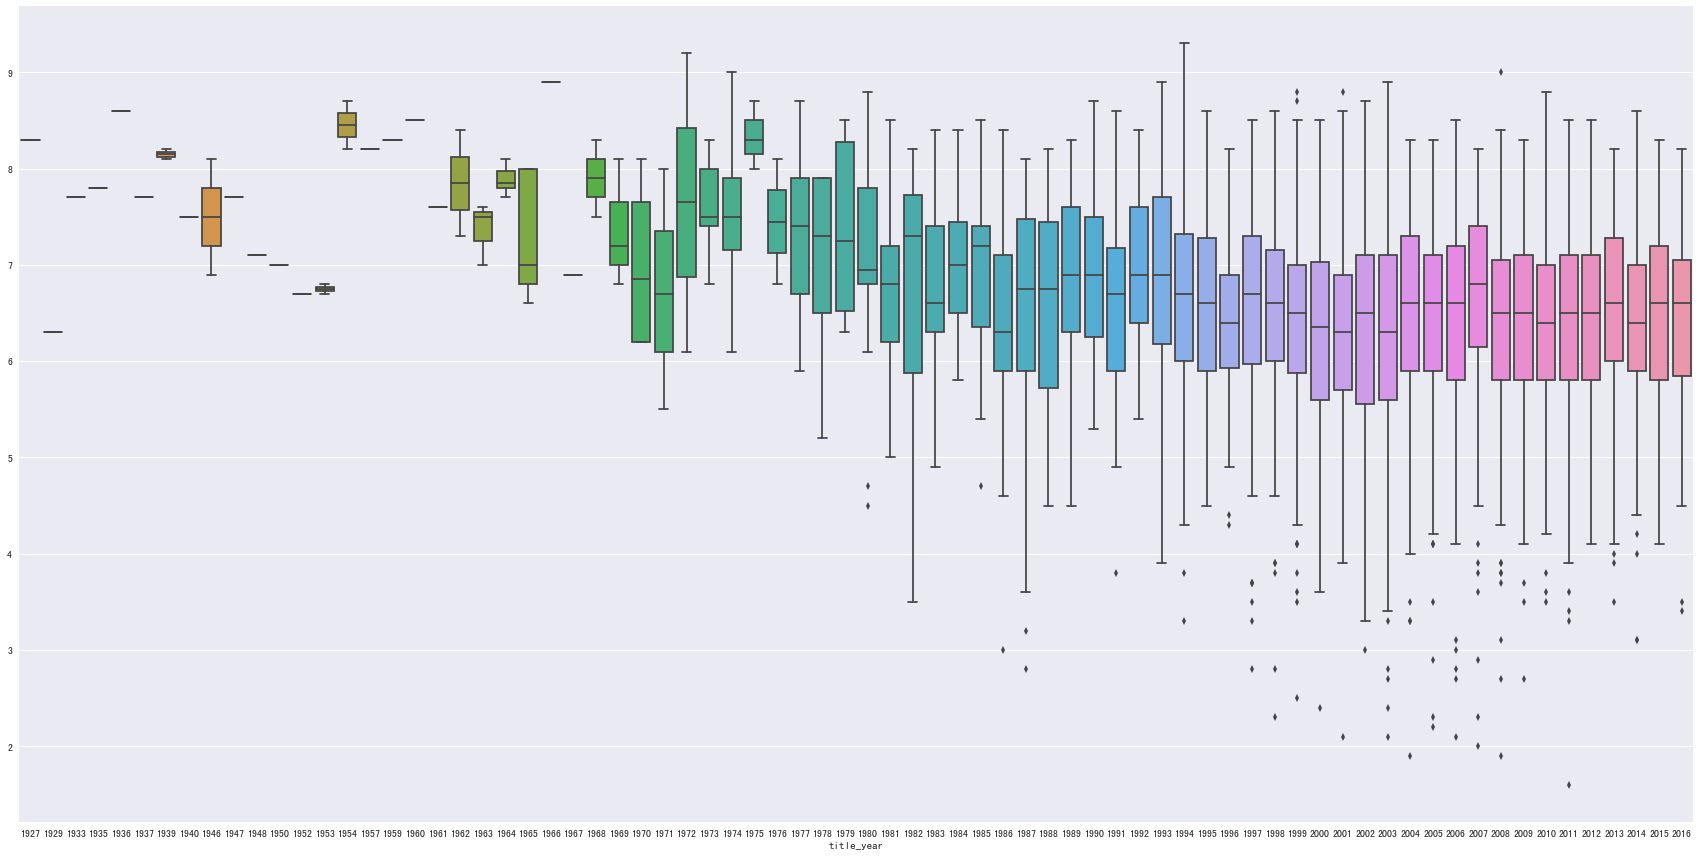

In [9]:
year_imdb = df.groupby('title_year')['imdb_score'].apply(list)
year_imdb = pd.DataFrame(year_imdb)
for index in year_imdb.index.values:
    for col in year_imdb.columns.values:
        if(type(year_imdb.loc[index, col])) == list:  
            for i in range (len(year_imdb.loc[index, col])):   
                year_imdb.loc[index, i] = year_imdb.loc[index, col][i]   
del year_imdb['imdb_score']
plt.subplots(figsize=(30,15))
sns.boxplot(data = year_imdb.T)

### 電影的出產地區、語種 - 圓餅圖

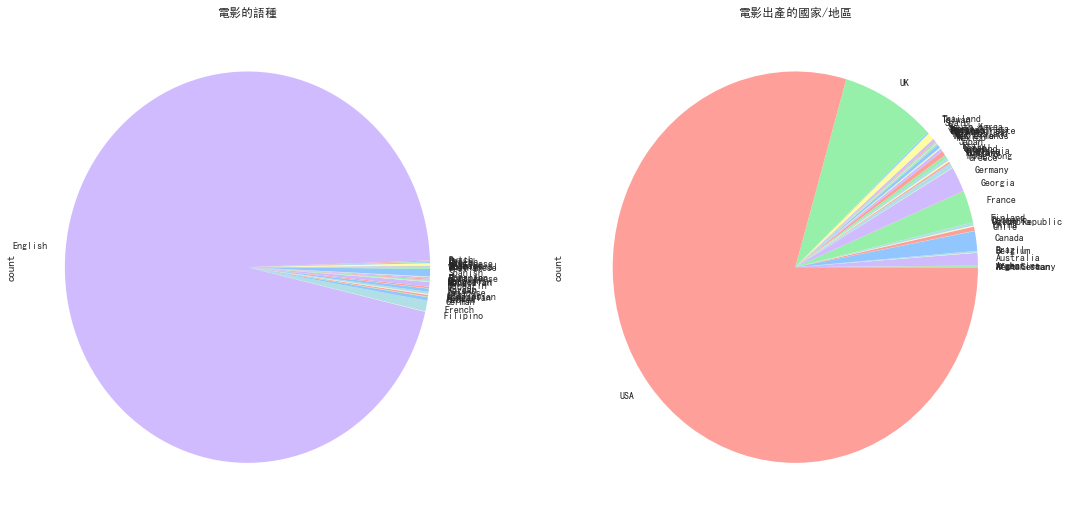

In [10]:
plt.rcParams['font.family']='SimHei' 
plt.figure(figsize=(18,9))
plt.style.use('seaborn-pastel')
language = df.groupby('language')['count'].sum()
plt.subplot(121)
language.plot(kind = 'pie')
plt.title('電影的語種')

country = df.groupby('country')['count'].sum()
plt.subplot(122)
country.plot(kind = 'pie')
plt.title('電影出產的國家/地區')

### IMDB分數與評論數之相關

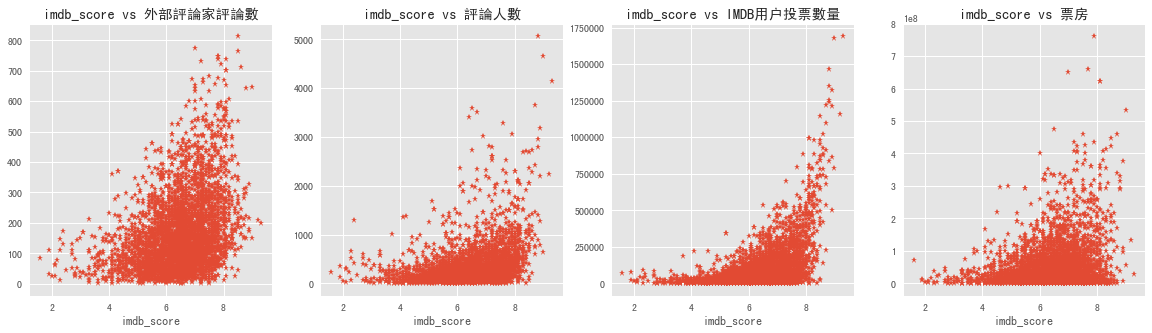

In [11]:
plt.rcParams['font.family']='SimHei' 
plt.style.use('ggplot')
plt.figure(figsize = (20,5))
ax1 = plt.subplot(141)
plt.plot(df.imdb_score, df.num_critic_for_reviews, '*')
plt.title('imdb_score vs 外部評論家評論數')
plt.xlabel('imdb_score')

ax1 = plt.subplot(142)
plt.plot(df.imdb_score, df.num_user_for_reviews, '*')
plt.title('imdb_score vs 評論人數')
plt.xlabel('imdb_score')

ax1 = plt.subplot(143)
plt.plot(df.imdb_score, df.num_voted_users, '*')
plt.title('imdb_score vs IMDB用户投票數量')
plt.xlabel('imdb_score')

ax1 = plt.subplot(144)
plt.plot(df.imdb_score, df.gross, '*')
plt.title('imdb_score vs 票房')
plt.xlabel('imdb_score')

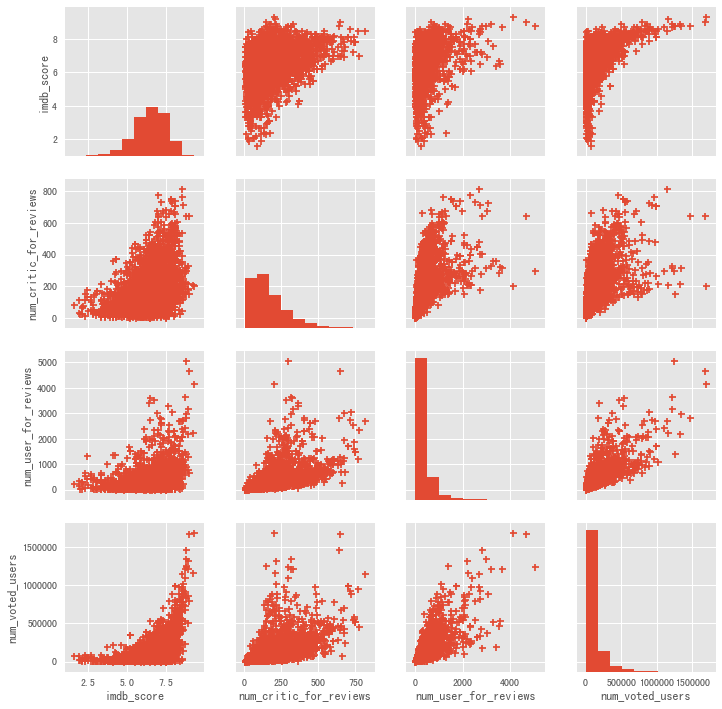

In [12]:
score_review = df[['imdb_score','num_critic_for_reviews','num_user_for_reviews','num_voted_users']]
sns.pairplot(score_review, markers="+")

### 各電影類型的數量

In [13]:
#將電影類型取出來 一個類型為一列
df_clean = df[['genres', 'title_year']].dropna()
df_genre = pd.DataFrame(columns = ['genres', 'year'])
def genreRemap(row):
    global df_genre
    d = {}
    genres = np.array(row['genres'].split('|'))
    n = genres.size
    d['year'] = [row['title_year']]*n
    d['genre'], d['cgenres'] = [], []
    for genre in genres:
        d['genre'].append(genre)
        d['cgenres'].append(genres[genres != genre])
    df_genre = df_genre.append(pd.DataFrame(d), ignore_index = True)
df_clean.apply(genreRemap, axis = 1)
df_genre['year'] = df_genre['year'].astype(np.int16)
df_genre = df_genre[['genre','cgenres', 'year']]
df_genre.head()

,genre,cgenres,year
0,Action,"[Adventure, Fantasy, Sci-Fi]",2009
1,Adventure,"[Action, Fantasy, Sci-Fi]",2009
2,Fantasy,"[Action, Adventure, Sci-Fi]",2009
3,Sci-Fi,"[Action, Adventure, Fantasy]",2009
4,Action,"[Adventure, Fantasy]",2007


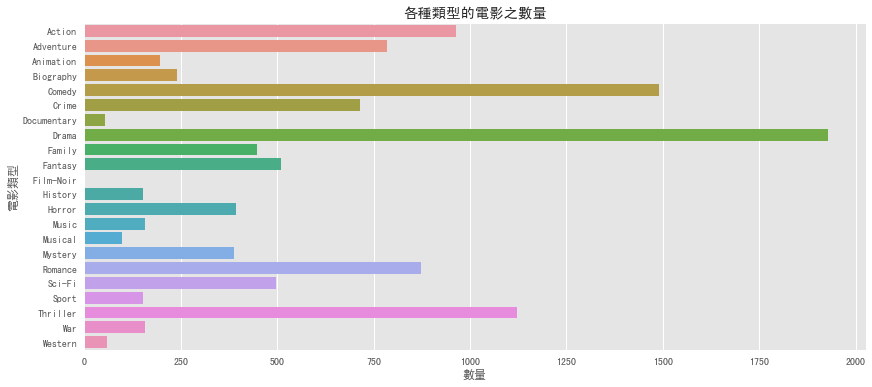

In [14]:
plt.rcParams['font.family']='SimHei'   # 顯示中文 且為黑體
genre_count = df_genre['genre'].value_counts().sort_index()
df_gCount = pd.DataFrame({'genre': genre_count.index, 'count': genre_count.values})
f, ax = plt.subplots(figsize = (14,6))
sns.barplot(x = 'count', y = 'genre', data = df_gCount)
ax.set_title('各種類型的電影之數量')
ax.set_xlabel('數量')
ax.set_ylabel('電影類型')

In [15]:
#依年份觀察 各電影類型數量
# year_2016
year_2016 = df_genre[df_genre['year']==2016]
year_2016_count = year_2016['genre'].value_counts().sort_index()
year_2016_gCount = pd.DataFrame({'genre': year_2016_count.index, 'count': year_2016_count.values})

# year_2015
year_2015 = df_genre[df_genre['year']==2015]
year_2015_count = year_2015['genre'].value_counts().sort_index()
year_2015_gCount = pd.DataFrame({'genre': year_2015_count.index, 'count': year_2015_count.values})

# year_2014
year_2014 = df_genre[df_genre['year']==2014]
year_2014_count = year_2014['genre'].value_counts().sort_index()
year_2014_gCount = pd.DataFrame({'genre': year_2014_count.index, 'count': year_2014_count.values})

# year_2013
year_2013 = df_genre[df_genre['year']==2013]
year_2013_count = year_2013['genre'].value_counts().sort_index()
year_2013_gCount = pd.DataFrame({'genre': year_2013_count.index, 'count': year_2013_count.values})

# year_2012
year_2012 = df_genre[df_genre['year']==2012]
year_2012_count = year_2012['genre'].value_counts().sort_index()
year_2012_gCount = pd.DataFrame({'genre': year_2012_count.index, 'count': year_2012_count.values})

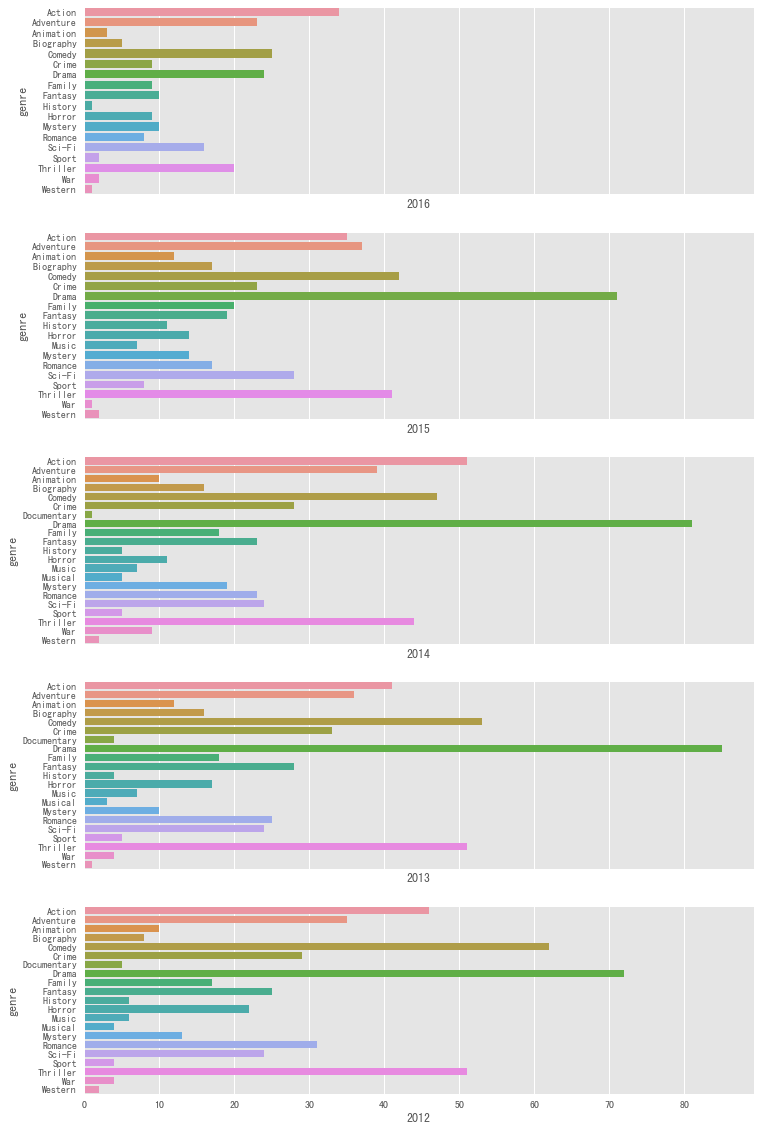

In [16]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, sharex=True, figsize=(12, 20))

sns.barplot(x = 'count', y = 'genre', data = year_2016_gCount, ax = ax1 ); ax1.set_xlabel('2016')
plt.setp(ax1.get_xticklabels(), visible=False)
sns.barplot(x = 'count', y = 'genre', data = year_2015_gCount, ax = ax2 ); ax2.set_xlabel('2015')
plt.setp(ax2.get_xticklabels() , visible=False)
sns.barplot(x = 'count', y = 'genre', data = year_2014_gCount, ax = ax3 ); ax3.set_xlabel('2014')
plt.setp(ax3.get_xticklabels() , visible=False)
sns.barplot(x = 'count', y = 'genre', data = year_2013_gCount, ax = ax4 ); ax4.set_xlabel('2013')
plt.setp(ax4.get_xticklabels() , visible=False)
sns.barplot(x = 'count', y = 'genre', data = year_2012_gCount, ax = ax5 ); ax5.set_xlabel('2012')

In [17]:
# 每國電影總產量 與 宣傳海報上臉出現的平均
country_face = df.groupby(['country'])['facenumber_in_poster'].mean()
country_face = pd.DataFrame(country_face)
country_sum = df.groupby(['country'])['count'].sum()
country_sum = pd.DataFrame(country_sum)
face = pd.merge(country_face, country_sum, left_index=True, right_index=True, how = 'outer')
#只留下 產量超過5部電影之國家資料
face[face['count']>=5]

,facenumber_in_poster,count
country,,
Australia,1.050000,40
Brazil,0.800000,5
Canada,1.145161,62
China,1.692308,13
Denmark,0.777778,9
France,1.078431,102
Germany,1.400000,80
Hong Kong,1.000000,13
India,2.000000,5
